# Design Reliability Analysis using `duqo`

TLDR; Following is an introduction to reliability analysis. Proceed to next cell if you are already familiar with it.

Before conducting design reliability analysis, let us define it first. In engineering design, there are often various criteria to describe design safety and failure. One possible formulation is using limit state functions. A limit state function $g(x): \mathbb{R}^n \rightarrow \mathbb{R}$ is similar to a constraint, in that it defines the safe region using a limit state value, e.g. a design is safe, if $g(x) \geq 0$. Now consider that $x$ is a draw from random variable (for example due to tolerance fields of the design variables or epistemic uncertainies such as measurement errors). Let us denote this as $x \sim F_X$, where $F_X: \mathbb{R}^n \rightarrow \mathbb{R}$ is the joint CDF. In this case, $G = g(X)$ is also a random variable. Despite the deterministic relationship $g(\cdot)$, the distribution $F_G$ of $G$ may be unknown in a practical sense (intractable, to expensive to compute, etc.) Thus, the condition $g(x) \geq 0$ is now an event $\mathcal{F}: G \geq 0$, which is often called *failure*, with a probability $P(\mathcal{F}) = P(G < 0)$. Reliability analysis aims to estimate this probability. 

If $F_G$ is known, the failure probability can be computed directly. Since we assume it to be unknown but the input uncertainties $F_X$ to be known, the following multi-dimensional integral has to be solved for computing 

$$ P(\mathcal{F}) = \int \dots \int_{g(x_1, \dots, x_n) < 0} f_X(x_1, \dots, x_n) d x_1 \dots d x_n $$

where $f_X$ is the joint PDF. Note that this integral can be very burdensome to compute depending on $f_x$ and $g$ as well as the number of dimensions $n$ and the failure probability $P(\mathcal{F})$ depending on the method. Thus, various methods for reliability analysis exist.`duqo` currently implements only two of them, directional sampling and monte carlo simulation. More methods such as subset simulation, importance sampling etc. are planned if there is community interest. Please make an issue (after checking that it does not already exist).

In [1]:
# Imports
from time import time
import numpy as np
import matplotlib.pyplot as plt
from duqo.stoch import UniVar, MultiVar # We will use these to define the input CDF F_x
from duqo.proba import MC, DS # These are the methods that we will test

integrator_classes = [MC, DS]

In [2]:
# Define two limit state functions
def himmblau(x, gamma=1):
    if x.ndim < 2:
        x = x.reshape((1, -1))
    res = ((x[:, 0] ** 2 + x[:, 1]) / 1.81 - 11) ** 2
    res += ((x[:, 0] + x[:, 1] ** 2) / 1.81 - 7) ** 2
    return res - 45 * gamma

def tricky_cos(x):
    if x.ndim < 2:
        x = x.reshape((1, -1))
    alpha = 1.475
    return 7. - np.sum((x / alpha) ** 2 - 5 * np.cos(2 * np.pi * x / alpha), axis=1)

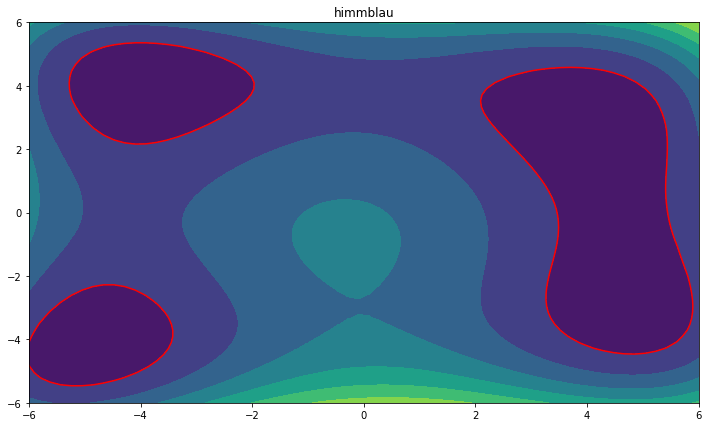

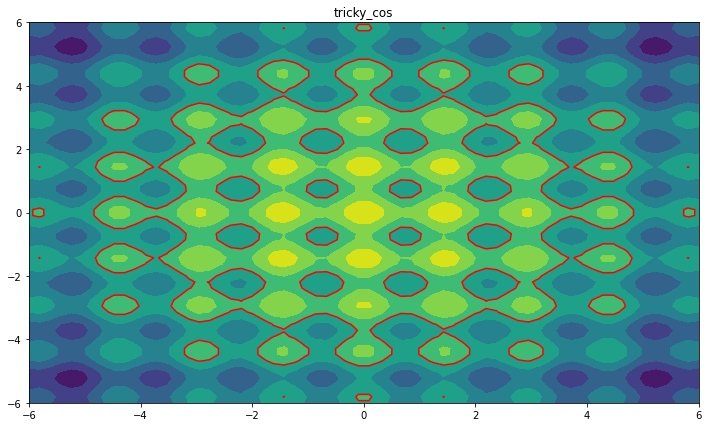

In [3]:
# Plot over [-6, 6] for both variables
def surface_plot(bounds, fun):
    grid = np.linspace(bounds[0], bounds[1], 64)
    X, Y = np.meshgrid(grid, grid)
    # Flatten to shape = (samples, dims)
    inps = np.c_[X.ravel(), Y.ravel()]
    Z = fun(inps).reshape(X.shape)
    fig, ax = plt.subplots(figsize=(12, 7))
    ax.contourf(X, Y, Z)
    ax.contour(X, Y, Z, colors="r", levels=[0]) # The zero line
    ax.set_title(fun.__name__)
    return ax

plot_bounds = [-6, 6]
_ = surface_plot(plot_bounds, himmblau)
_ = surface_plot(plot_bounds, tricky_cos)



In [4]:
# Now define the input uncertainty
# For simplicity, let us use independent standard normal variables. Other distributions as well as linear dependence
# is also supported
multivar_stdnorm = MultiVar([UniVar("norm", mean=0, std=1) for _ in range(2)])
# Now we are ready to rock some probabilities!

In [5]:
# Test Himmblau
constraints = [himmblau]
for integrator_cls in integrator_classes:
    integrator = integrator_cls(multivar_stdnorm, constraints)
    t0 = time()
    fail_prob, _, _, _ = integrator.calc_fail_prob(prob_tol=1e-4, post_proc=False, verbose=0, converge=False)
    print(integrator_cls.__name__, f": {fail_prob:.2e} ({time() - t0:4f}  s.)")

# MC gets inefficient for small failure probabilities.
for integrator_cls in integrator_classes:
    integrator = integrator_cls(multivar_stdnorm, constraints)
    t0 = time()
    # prob_tol is an estimation of the smallest failure probability of interest
    fail_prob, _, _, _ = integrator.calc_fail_prob(prob_tol=1e-6, post_proc=False, verbose=0, converge=False)
    print(integrator_cls.__name__, f": {fail_prob:.2e} ({time() - t0:4f}  s.)")


MC : 6.50e-04 (0.109002  s.)
DS : 6.51e-04 (1.123999  s.)
MC : 6.41e-04 (7.623298  s.)
DS : 6.53e-04 (0.229999  s.)


In [6]:
# Test Tricky
constraints = [tricky_cos]
for integrator_cls in integrator_classes:
    integrator = integrator_cls(multivar_stdnorm, constraints)
    t0 = time()
    fail_prob, _, _, _ = integrator.calc_fail_prob(post_proc=False, verbose=0)
    print(integrator_cls.__name__, f": {fail_prob:.2e} ({time() - t0:4f}  s.)")

# The difference is quite large due to original formulation of DS which is the default configuration.
# To solve such highly multi modal problems, multi_region should be set to True, which inevitably will increase
# the inference duration
integrator = DS(multivar_stdnorm, constraints)
t0 = time()
fail_prob, _, _, _ = integrator.calc_fail_prob(post_proc=False, verbose=0, converge=False, multi_region=True)
print(integrator_cls.__name__, f"() : {fail_prob:.2e} ({time() - t0:4f}  s.)")



MC : 1.41e-01 (0.011999  s.)
DS : 2.95e-01 (0.536190  s.)
DS () : 1.39e-01 (2.268554  s.)


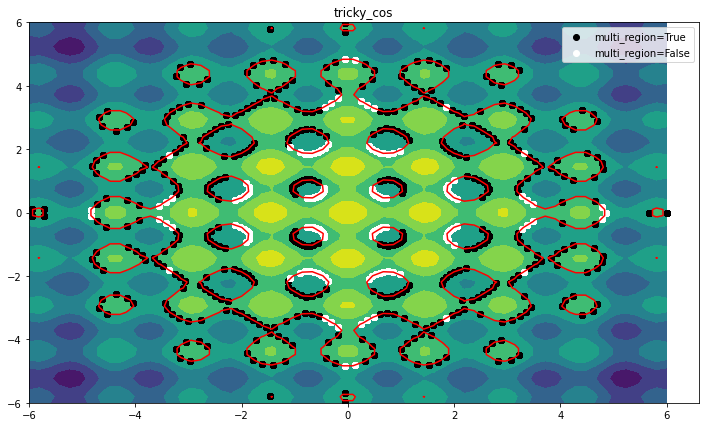

In [7]:
# Let us visualize the difference using a plot
ds1 = DS(multivar_stdnorm, constraints)
ds2 = DS(multivar_stdnorm, constraints)
_ = ds1.calc_fail_prob(post_proc=True, verbose=0, multi_region=True, num_parallel=1)
_ = ds2.calc_fail_prob(post_proc=True, verbose=0, multi_region=False, num_parallel=1)
ax = surface_plot(plot_bounds, tricky_cos)
ax.scatter(ds1.x_lsf[:, 0], ds1.x_lsf[:, 1], color="k", label="multi_region=True")
ax.scatter(ds2.x_lsf[:, 0], ds2.x_lsf[:, 1], color="w", label="multi_region=False")
_ = ax.legend()
# As you can see, multi_region=False only considers the first failure region in each direction,
#while multi_region=True considers all of them within the search radius

## Extra: System reliability

In system reliability, the failure event is sometimes defined as $P(\mathcal{F}) = P(\min(\{g_{k}(x); \; k \in [1, n_g\}))$, where $n_g$ is the number of limit state conditions. This kind of probability can also be computed with `duqo` by passing a list of functions.

In [8]:
# Test Both
constraints = [tricky_cos, himmblau]
for integrator_cls in [MC, DS]:
    integrator = integrator_cls(multivar_stdnorm, constraints)
    t0 = time()
    fail_prob, _, _, _ = integrator.calc_fail_prob(post_proc=False, verbose=0, multi_region=True)
    print(integrator_cls.__name__, f": {fail_prob:.2e} ({time() - t0:4f}  s.)")
# The only caveat is now you only get the system failure probability. Thus, reevaluation with indiviudal lsfs are
# currently required to acquire individual failure probabilities

MC : 1.43e-01 (0.014002  s.)
DS : 1.39e-01 (1.541032  s.)
